In [15]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature
import pickle
from sklearn.preprocessing import StandardScaler
import random
import pickle

In [3]:
from cars_detector.utils  import read_test_frame, read_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features, compute_colors_features
from cars_detector.makebox import non_max_suppression, box_otsu
from cars_detector.splitpictures import pyramid

In [4]:
df_ground_truth = pd.read_csv('./train.csv')

## Sampling of positive and negative examples

In [5]:
total_positive_samples, total_negative_samples = sampling(df_ground_truth)

100%|██████████| 2225/2225 [01:49<00:00, 20.34it/s]


In [11]:
total_negative_samples = random.sample(total_negative_samples, 60000)
total_positive_samples = random.sample(total_positive_samples, 30000)

In [5]:
if os.path.isfile("data/pos_neg_samples/positive_samples.pkl") and os.path.isfile("data/pos_neg_samples/negative_samples.pkl"):
    print('load data')
    total_positive_samples = pickle.load(open('data/pos_neg_samples/positive_samples.pkl', 'rb'))
    total_negative_samples = pickle.load(open('data/pos_neg_samples/negative_samples.pkl', 'rb'))

else:
    total_positive_samples, total_negative_samples = sampling(df_ground_truth)
    pickle.dump(total_negative_samples,open('data/pos_neg_samples/negative_samples.pkl', 'wb'))
    pickle.dump(total_positive_samples,open('data/pos_neg_samples/positive_samples.pkl', 'wb'))
    


  0%|          | 0/2225 [00:00<?, ?it/s]

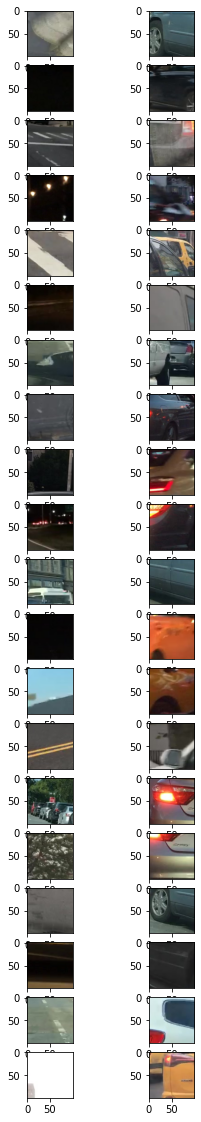

In [12]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)
fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]
        ax[i][j].imshow(img)

## Data Augmentation

In [13]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.1
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

for img in tqdm(total_negative_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_negative_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/30000 [00:00<?, ?it/s]/home/33631/cars_detection/venv/lib/python3.7/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 60000/60000 [00:03<00:00, 18039.72it/s]


In [14]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 33124
number of negative samples: 66010


## Features computation

In [4]:
if os.path.isfile("data/features/positive_features.pkl") and os.path.isfile("data/features/negative_features.pkl"):
    print('load data')
    positive_features = pickle.load(open("data/features/positive_features.pkl", 'rb'))
    negative_features = pickle.load(open("data/features/negative_features.pkl", 'rb'))
else:
    print('compute features')
    positive_features = []
    for img in tqdm(total_positive_samples, position = 0):
        feat = compute_features(img)
        positive_features.append(feat)
    pickle.dump(positive_features,open("data/features/positive_features.pkl", 'wb'))

    negative_features = []
    for img in tqdm(total_negative_samples, position = 0):
        feat = compute_features(img)
        negative_features.append(feat)
    pickle.dump(positive_features,open("data/features/negative_features.pkl", 'wb'))

load data


In [5]:
from sklearn.model_selection import train_test_split
X = np.concatenate((positive_features,negative_features), axis = 0)
y = np.array([1 for i in range(len(positive_features))]+[0 for i in range(len(negative_features))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# creata weight matrix
weight_ratio = float(len(y_train[y_train == 0]))/float(len(y_train))
w_array = np.zeros(y_train.shape[0])
w_array[y_train==1] = weight_ratio
w_array[y_train==0] = 1- weight_ratio

In [7]:
if os.path.isfile('data/models/XGB.sav'):
    print('load model')
    clf = pickle.load(open('data/models/XGB.sav', 'rb'))
else:
    clf = XGBClassifier()
    clf.fit(X_train, y_train, sample_weight=w_array)
    pickle.dump(clf, open('data/models/XGB.sav', 'wb'))


y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")


load model
accuracy: 0.926673751328374


## Pyramid Window Sliding

In [19]:
# Define blocks and steps as above
def get_heat_map_with_window_sliding(img):
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9
    cells_per_step = 2
    window = 64
    scale_step=1.5
    bboxes = []
    pred_array = np.zeros((img.shape[0], img.shape[1]), dtype = float)
    for i,test_img in enumerate(pyramid(img, scale=scale_step, minSize=(256, 256))):
        scale = scale_step**i
        nxblocks = (test_img.shape[1] // pix_per_cell)-1
        nyblocks = (test_img.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = feature.hog(test_img[:,:,0], orient, (pix_per_cell,pix_per_cell), (cell_per_block, cell_per_block), feature_vector=False)
        hog2 = feature.hog(test_img[:,:,1], orient, (pix_per_cell,pix_per_cell), (cell_per_block, cell_per_block), feature_vector=False)
        hog3 = feature.hog(test_img[:,:,2], orient, (pix_per_cell,pix_per_cell), (cell_per_block, cell_per_block), feature_vector=False)
    
        for xb in range(nxsteps+1):
            for yb in range(nysteps+1):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(test_img[ytop:ytop+window, xleft:xleft+window], (100,100))
                
                color_features = compute_colors_features(subimg)
                features = np.concatenate((hog_features, color_features))

                # Scale features and make a prediction
                test_features = scaler.transform([features])
                test_prediction = clf.predict(test_features)
                
                if test_prediction == 1:
                    xbox_left = np.int32(xleft*scale)
                    ytop_draw = np.int32(ytop*scale)
                    win_draw = np.int32(window*scale)
                    box = [xbox_left,ytop_draw, win_draw,win_draw] 
                    bboxes.append(box)
                    pred_array[ytop_draw:ytop_draw+win_draw, xbox_left:xbox_left+win_draw] += 1
    # do not consider front of the car
    pred_array[500:,:]= 0
    return(bboxes, pred_array)
                


In [20]:
def filter_boxes(bboxes,pred_array):
    boxes_to_keep = []
    means_list = []

    bin =  np.bincount(pred_array.ravel().astype('int'))
    threshold = np.argmax(bin/np.cumsum(bin) < 0.1)

    for box in bboxes:
        if len(box) > 0:
            try:
                mean_pred = np.mean(pred_array[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])
                means_list.append(mean_pred)
                if mean_pred > threshold:
                    boxes_to_keep.append(box)
            except:
                continue
    return(boxes_to_keep)

In [21]:
def non_max_suppression(boxes, overlapThresh = 0.4):
    # Return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = x1+boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = y1+boxes[:, 3]  # y coordinate of the bottom-right corner
    # Compute the area of the bounding boxes and sort the bounding
    # Boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We add 1, because the pixel at the start as well as at the end counts
    # The indices of all boxes at start. We will redundant indices one by one.
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        # Create temporary indices  
        temp_indices = indices[indices!=i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[0]+box[2], boxes[temp_indices,0]+boxes[temp_indices,2])
        yy2 = np.minimum(box[1]+box[3], boxes[temp_indices,1]+boxes[temp_indices,3])
        # Find out the width and the height of the intersection box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index  
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    #return only the boxes at the remaining indices
    return boxes[indices].astype(int)

In [ ]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [22]:
from skimage.io import imread
images_list = os.listdir('test/')
submission_df = pd.read_csv('sample_submission.csv')
submission_df = submission_df.drop(index = [0])
for img_path in tqdm(images_list, position=0):
    img = imread('./test/'+img_path)

    (bboxes, pred_array) = get_heat_map_with_window_sliding(img)

    # filter boxes
    boxes_to_keep = filter_boxes(bboxes,pred_array)

    # non max suppresion
    new_boxes = non_max_suppression(np.array(boxes_to_keep), 0.4)

    predictions = np.array(new_boxes).ravel()

    final_pred = ' '.join(predictions.astype(str))

    line_to_add = pd.DataFrame([['test/'+img_path, final_pred]], columns = submission_df.columns)
    submission_df  = pd.concat([submission_df, line_to_add], axis = 0)

# pre saving in order not to loose everything    
submission_df.to_csv('final_predictions.csv', index=False)
# convert prediction to the right format
preds = []
for i in range(submission_df.shape[0]):

    bbs = list(map(int, submission_df.iloc[i].Predicted.split(" ")))
    bbs = np.array_split(bbs, len(bbs) / 4)

    mask = bounding_boxes_to_mask(bbs, 720, 1280)
    pred = run_length_encoding(mask)
    preds.append(pred)

submission_df.Predicted = preds

submission_df.to_csv('final_predictions.csv', index=False)

  0%|          | 0/202 [00:00<?, ?it/s]c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/202 [01:05<3:38:33, 65.24s/it]c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  1%|          | 2/202 [02:03<

In [37]:
submission_df.to_csv('final_predictions.csv', index=False)